In [1]:
data <- read.csv('neighbour_pressure.csv')

Some feature combinations are very rare and will not be useful for model testing. We restrict the dataset to 98 feature combinations present in 20 languages and more.

In [2]:
feature_counts = xtabs(feature_present ~ feature_name, data = data)
popular.segments = names(feature_counts[which(feature_counts >= 20)])
print(length(popular.segments))
data <- data[which(data$feature_name %in% popular.segments),]

[1] 98


In [3]:
dim(data)

[1] 46452     6

In [4]:
summary(data)

    density                                         feature_name  
 Min.   : 0.0000   alveolar affricate voiced              :  474  
 1st Qu.: 0.2227   alveolar affricate voiceless           :  474  
 Median : 1.1632   alveolar affricate voiceless aspirated :  474  
 Mean   : 2.7228   alveolar approximant voiced            :  474  
 3rd Qu.: 3.9961   alveolar approximant voiced palatalised:  474  
 Max.   :19.7697   alveolar approximant voiceless         :  474  
                   (Other)                                :43608  
 feature_present         genus                     lang      
 Min.   :0.0000   Tibetic   : 3626   Abkhaz (Bzyb)   :   98  
 1st Qu.:0.0000   Iranic    : 2156   Abujmaria       :   98  
 Median :0.0000   Indic     : 2058   Achang (Lianghe):   98  
 Mean   :0.2551   Germanic  : 1666   Adyghe          :   98  
 3rd Qu.:1.0000   Romance   : 1666   Aheu; Thavung   :   98  
 Max.   :1.0000   Indo-Aryan: 1568   Ahi             :   98  
                  (Other)   :3

In [5]:
positives <- data[which(data$feature_present == 1),]
negatives <- data[which(data$feature_present == 0),]

Visual illustration of the connection between presence/absence of feature combinations and their densities in the graph.

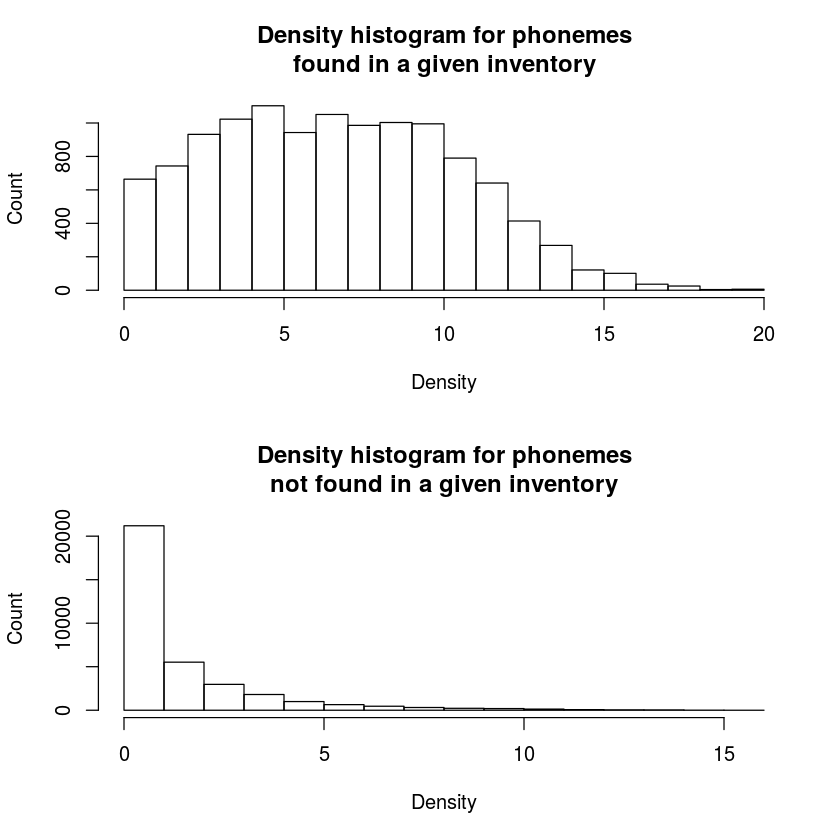

In [6]:
par(mfrow = c(2,1))
hist(positives$density, main = 'Density histogram for phonemes\nfound in a given inventory',
     xlab = 'Density', ylab = 'Count')
hist(negatives$density, main = 'Density histogram for phonemes\nnot found in a given inventory',
     xlab = 'Density', ylab = 'Count')

Density is highly significant for predicting presence of feature combinations. However, we cannot be sure that this is not due to the influence of the genetic relatedness since related languages also tend to cluster together geographically.

In [7]:
general.density.fit <- glm(feature_present ~ density, family = 'binomial', data = data)
summary(general.density.fit)


Call:
glm(formula = feature_present ~ density, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4269  -0.4529  -0.3452   0.1160   2.4348  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.911099   0.022857  -127.4   <2e-16 ***
density      0.551032   0.005234   105.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 52755  on 46451  degrees of freedom
Residual deviance: 31938  on 46450  degrees of freedom
AIC: 31942

Number of Fisher Scoring iterations: 5


Using languages from major families, we can estimate relative importance of NP vs. phyla for predicting whether a feature combination will be found in a given language. We compare models using ROC-AUC metric with leave-one-out cross-validation.

In [8]:
MAJOR_FAMILIES = c('Mongolic',
                   'Tai-Kadai',
                   'Austronesian',
                   'Nakh-Daghestanian',
                   'Turkic',
                   'Dravidian',
                   'Uralic',
                   'Mon-Khmer',
                   'Sino-Tibetan',
                   'Indo-European')

# Not all feature combinations are found in the languages
# of these families. Moreover, some features are found
# in almost languages of the sample (431 at this moment),
# and they are also hard to predict.
feature.popularity.major.families <- xtabs(feature_present ~ feature_name,
                                           data = data[which(data$phylum %in% MAJOR_FAMILIES),])
features.from.major.families <- names(feature.popularity.major.families[which(feature.popularity.major.families > 0 &
                                                                              feature.popularity.major.families < 400)])
data.major <- data[which(data$phylum %in% MAJOR_FAMILIES &
                         data$feature_name %in% features.from.major.families),]
data.major <- droplevels(data.major)

In [9]:
summary(data.major)

    density                                           feature_name  
 Min.   : 0.000005   alveolar affricate voiced              :  431  
 1st Qu.: 0.229238   alveolar affricate voiceless           :  431  
 Median : 1.164651   alveolar affricate voiceless aspirated :  431  
 Mean   : 2.575651   alveolar approximant voiced            :  431  
 3rd Qu.: 3.788157   alveolar approximant voiced palatalised:  431  
 Max.   :18.695098   alveolar approximant voiceless         :  431  
                     (Other)                                :38359  
 feature_present         genus                     lang      
 Min.   :0.0000   Tibetic   : 3515   Abujmaria       :   95  
 1st Qu.:0.0000   Iranic    : 2090   Achang (Lianghe):   95  
 Median :0.0000   Indic     : 1995   Aheu; Thavung   :   95  
 Mean   :0.2353   Germanic  : 1615   Ahi             :   95  
 3rd Qu.:0.0000   Romance   : 1615   Akha            :   95  
 Max.   :1.0000   Indo-Aryan: 1520   Aklan           :   95  
              

In [10]:
sort(xtabs(feature_present~feature_name, data = data.major),
     decreasing = T)

feature_name
                     palatal approximant voiced 
                                            391 
                    alveolar approximant voiced 
                                            366 
            alveolar lateral_approximant voiced 
                                            365 
                        bilabial plosive voiced 
                                            365 
                   alveolar fricative voiceless 
                                            362 
                           velar plosive voiced 
                                            335 
                          alveolar nasal voiced 
                                            333 
                             velar nasal voiced 
                                            301 
                    glottal fricative voiceless 
                                            283 
                labial-velar approximant voiced 
                                            277 
       

In [ ]:
require(pROC)

# Suppress warnings for now
oldw <- getOption("warn")
options(warn = -1)

results <- c()
for (q in unique(data.major$feature_name)) {
#     q <- sample(data.major$feature_name, size = 1)
#     q <- 'uvular plosive voiceless'
    print(q)
    d <- data.major[which(data.major$feature_name == q),]
    d <- droplevels(d)
    
    densities.cv.results <- data.frame('response' = c(),
                                       'prediction' = c())
    phylum.cv.results <- data.frame('response' = c(),
                                    'prediction' = c())
    both.cv.results <- data.frame('response' = c(),
                                   'prediction' = c())
    # Leave-one-out cross-validation
    # with ROC-AUC metric
    for (i in 1:nrow(d)) {
        train.data <- d[-i,]
        test.data <- d[i,]
        response <- test.data$feature_present
        fit.densities <- glm(feature_present ~ density,
                         family = 'binomial', data = d)
        fit.phylum <- glm(feature_present ~ phylum,
                      family = 'binomial', data = d)
        fit.both <- glm(feature_present ~ density + phylum,
                    family = 'binomial', data = d)
        densities.cv.results <- rbind(densities.cv.results,
                                     data.frame('response' = response,
                                                'prediction' = predict(fit.densities, test.data)))
        phylum.cv.results <- rbind(phylum.cv.results,
                                  data.frame('response' = response,
                                            'prediction' = predict(fit.phylum, test.data)))
        both.cv.results <-rbind(both.cv.results,
                               data.frame('response' = response,
                                         'prediction' = predict(fit.both, test.data)))
    }
    densities.roc <- roc(response~prediction, data = densities.cv.results)
    phylum.roc <- roc(response~prediction, data = phylum.cv.results)
    both.roc <- roc(response~prediction, data = both.cv.results)
    results <- c(results, sprintf("densities: %.3f, phylum: %.3f, both: %.3f (%s)",
                                  auc(densities.roc),
                                  auc(phylum.roc),
                                  auc(both.roc),
                                  q))
}
# Resume receiving warnings
options(warn = oldw)

Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



[1] "bilabial plosive voiceless palatalised"
[1] "densities: 0.822, phylum: 0.792, both: 0.863 (bilabial plosive voiceless palatalised)"
[1] "bilabial plosive voiceless aspirated"
[1] "densities: 0.845, phylum: 0.828, both: 0.878 (bilabial plosive voiceless aspirated)"
[1] "bilabial plosive voiceless glottalised"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

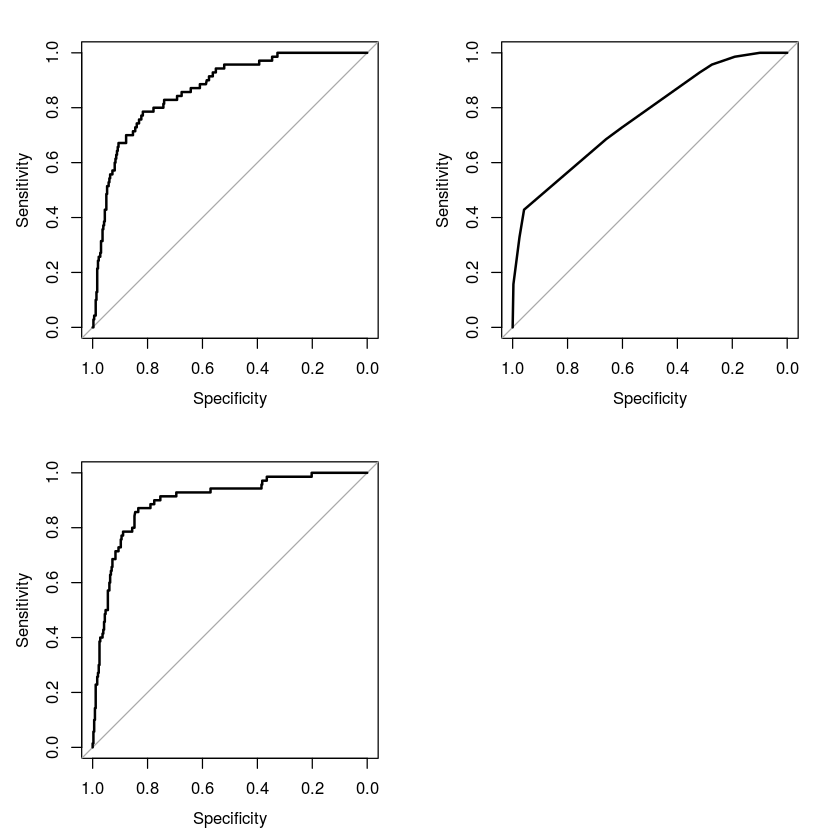

In [73]:
# Plots for "uvular plosive voiceless"
par(mfrow = c(2,2))
plot(densities.roc)
plot(phylum.roc)
plot(both.roc)

In [74]:
print(auc(densities.roc))
print(auc(phylum.roc))
print(auc(both.roc))

Area under the curve: 0.8666
Area under the curve: 0.7668
Area under the curve: 0.8975


Fit a model throwing away one language at a time and try to predict that language's inventory

In [119]:
performance.df <- data.frame('lang' = c(), 'seg.count' = c(),
                             'true.positives' = c(), 'true.negatives' = c(),
                             'false.positives' = c(), 'false.negatives' = c())
all.langs <- unique(data$lang)
for (i in 1:length(all.langs)) {
    l <- all.langs[i]
    lang.indexes <- which(data$lang == l)
    train.data <- data[-lang.indexes,]
    test.data <- data[lang.indexes,]
    local.fit <- glm(feature_present ~ density, family = 'binomial', data = train.data)
    predicted.probs <- predict(local.fit, newdata = test.data, type = 'response')
    predicted.segments <- round(predicted.probs)
    true.segments <- test.data$feature_present
    segment.count <- sum(true.segments)
    true.positives <- 0; true.negatives <- 0
    false.positives <- 0; false.negatives <- 0
    for (j in 1:length(true.segments)) {
        predicted.val <- predicted.segments[j]
        true.val <- true.segments[j]
        if (predicted.val == 1 && true.val == 1) {
            true.positives = true.positives + 1
        } else if (predicted.val == 1 && true.val == 0) {
            false.positives = false.positives + 1
        } else if (predicted.val == 0 && true.val == 1) {
            false.negatives = false.negatives + 1
        } else {
            true.negatives = true.negatives + 1
        }
    }
    performance.df <- rbind(performance.df, data.frame('lang' = c(as.character(l)),
                                                       'seg.count' = c(segment.count),
                                                       'true.positives' = c(true.positives),
                                                       'true.negatives' = c(true.negatives),
                                                       'false.positives' = c(false.positives),
                                                       'false.negatives' = c(false.negatives)))
}

In [126]:
require(reshape2)

Loading required package: reshape2


No id variables; using all as measure variables


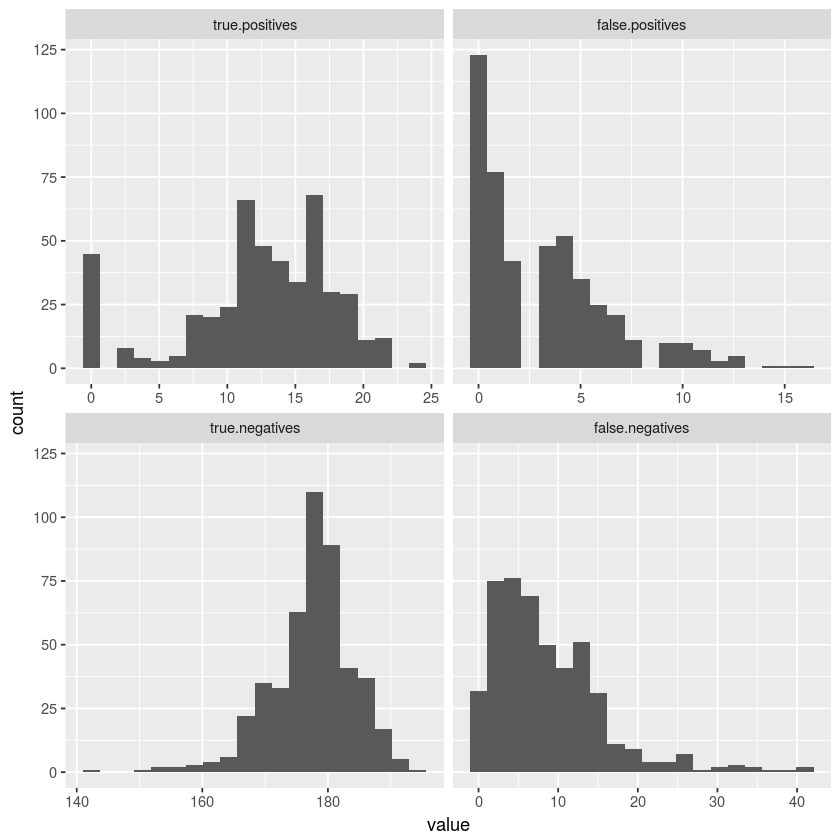

In [128]:
library(ggplot2)
ggplot(data = melt(performance.df[,c('true.positives', 'false.positives', 'true.negatives', 'false.negatives')]),
       mapping = aes(x = value)) + geom_histogram(bins = 20) + facet_wrap(~variable, scales = 'free_x')

In [129]:
precision.scores <- performance.df$true.positives / (performance.df$true.positives +
                                                     performance.df$false.positives)
recall.scores <- performance.df$true.positives / (performance.df$true.positives +
                                                  performance.df$false.negatives)
f1.scores <- 2 * (precision.scores * recall.scores) / (precision.scores + recall.scores)

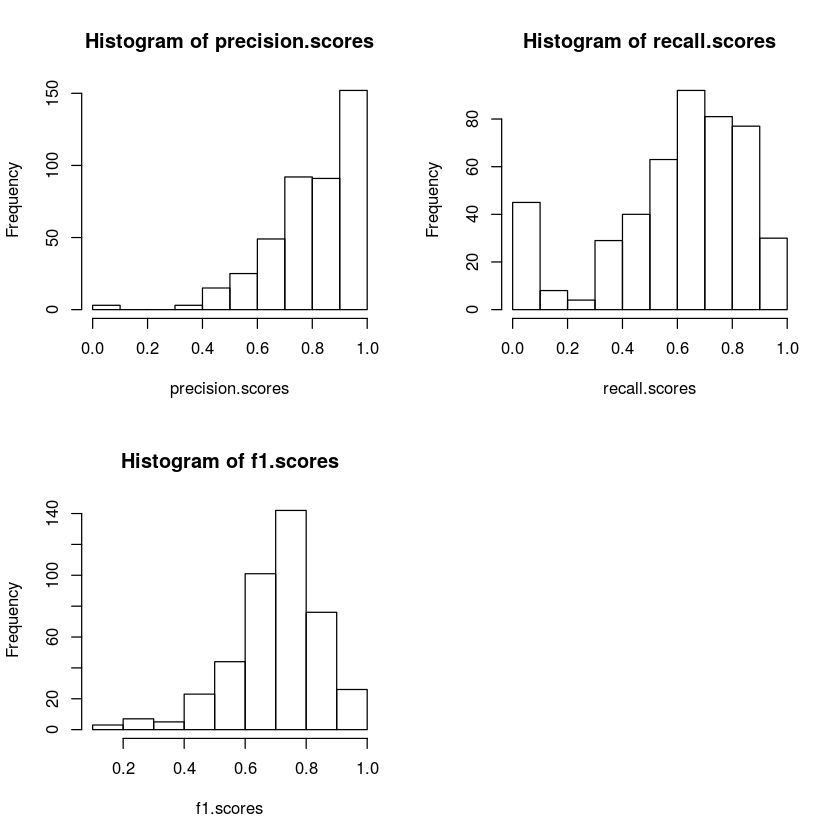

In [131]:
par(mfrow = c(2,2))
hist(precision.scores)
hist(recall.scores)
hist(f1.scores)

As is evident from the historgrams of true.positives and recall the model fail spectacularly with a particular set of languages. What are these languages?

In [133]:
black.sheep <- which(performance.df$true.positives <= 5)
all.langs[black.sheep]

[1] Southern Sama              Tiruray                   
 [3] Tausug (Jolo)              Portuguese (Estremenho)   
 [5] Manchu                     Solon                     
 [7] Icelandic                  Itelmen                   
 [9] Alutor                     Buriat (Standard)         
[11] Eastern Khanty (Vakh)      Ket (Kellog)              
[13] Nganasan (Avam)            Kamassian                 
[15] Nivkh (West Sakhalin)      Nanai                     
[17] Ainu                       Kolyma Yukaghir           
[19] Tundra Yukaghir            Mongolian (Khalkha)       
[21] Khalkha                    Standard Chinese (Beijing)
[23] Daur                       Darkhat                   
[25] Tuvan (Standard)           Northern Altai (Kumandy)  
[27] Uyghur (Xinjiang)          Hiligaynon                
[29] Kunigami (Nakijin)         Ter Saami                 
[31] Northern Mansi (Sośva)     Öñge; Ong; Onge           
[33] Nicobarese                 Jibbali (Central)         
[35] Mehri (Oman)               Konkani                   
[37] Mah Meri                   Naukan Yupik              
[39] Chukchi                    Jah-Hut                   
[41] Koryak                     Even (Ola)                
[43] Korean (Seoul)             Tofa                      
[45] Khakas (Standard)          Filipino                  
[47] Cebuano                    Taz Selkup                
[49] Najdi Arabic               Udihe (Bikin)             
[51] Japanese                   Maranao                   
[53] Kildin Saami               Forest Enets              
[55] Atayal                     Dolgan                    
[57] Sedik                      Tsou                      
[59] Badaga                     Koya                      
474 Levels: Abkhaz (Bzyb) Abujmaria Achang (Lianghe) Adyghe ... Zuberoan Basque

In [135]:
blackest.sheep <- which(performance.df$true.positives < 2)
all.langs[blackest.sheep]

[1] Southern Sama            Tiruray                  Tausug (Jolo)           
 [4] Portuguese (Estremenho)  Manchu                   Solon                   
 [7] Icelandic                Itelmen                  Alutor                  
[10] Buriat (Standard)        Nganasan (Avam)          Nivkh (West Sakhalin)   
[13] Nanai                    Ainu                     Kolyma Yukaghir         
[16] Tundra Yukaghir          Mongolian (Khalkha)      Khalkha                 
[19] Daur                     Darkhat                  Tuvan (Standard)        
[22] Northern Altai (Kumandy) Uyghur (Xinjiang)        Hiligaynon              
[25] Nicobarese               Jibbali (Central)        Mehri (Oman)            
[28] Konkani                  Mah Meri                 Naukan Yupik            
[31] Chukchi                  Jah-Hut                  Koryak                  
[34] Even (Ola)               Tofa                     Khakas (Standard)       
[37] Filipino                 Cebuano                  Najdi Arabic            
[40] Udihe (Bikin)            Japanese                 Maranao                 
[43] Forest Enets             Dolgan                   Koya                    
474 Levels: Abkhaz (Bzyb) Abujmaria Achang (Lianghe) Adyghe ... Zuberoan Basque

The two lists above show that the models fails where it should do: with languages that have a very limited number of neighbours in the Delaunay-graph.